In [1]:
import pandas as pd
import xgboost as xgb

import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [2]:
df_silnik050 = pd.read_csv('../data/df_silnik050.csv', sep="|")
#df_silnik045 = pd.read_csv('../data/df_silnik045.csv', sep="|") <-- nie znaleziono w danych tego przykładu:)
df_silnik175 = pd.read_csv('../data/df_silnik175.csv', sep="|")

In [3]:
df_wos = pd.concat([df_silnik050, df_silnik175], axis=0)

In [4]:
train, test = train_test_split(df_wos, train_size=0.3)

print(f'train: {train.shape}')
print(f'train: {test.shape}')

X_train = train.drop(['status','avg168_tempin','avg48_tempin','avg24_tempin','avg12_tempin','avg6_tempin','tempin'], axis = 1)
y_train = train[['status']]

X_test = test.drop(['status','avg168_tempin','avg48_tempin','avg24_tempin','avg12_tempin','avg6_tempin','tempin'], axis = 1)
y_test = test[['status']]

labelencoder = LabelEncoder()
y_train = pd.DataFrame(labelencoder.fit_transform(y_train[['status']]), columns=['status'])
y_test = pd.DataFrame(labelencoder.transform(y_test[['status']]), columns=['status'])

train: (1059, 109)
train: (2471, 109)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [5]:
param = {
    'n_estimators': 50,
    'max_depth': 5,
    'min_child_weight': 50,
    'colsample_bynode': 0.2,
    'eta': 0.02, 
    'gamma': 5} 

xgb_model = xgb.XGBClassifier(**param, random_state=42)

xgb_model.fit(X_train, y_train)

# Predykcje i moc
preds_train = pd.DataFrame(xgb_model.predict_proba(X_train), columns = ['bez_awarii', 'awaria'])
preds =pd.DataFrame(xgb_model.predict_proba(X_test), columns = ['bez_awarii', 'awaria'])

metrics.roc_auc_score(y_test, preds['awaria'])

[01:10:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


0.9850546836381611

In [6]:
xgb_model.get_booster().get_score(importance_type="gain")

{'avg168_groilp': 55.930888175,
 'avg168_intaket': 38.153352340000005,
 'avg168_trnlup': 96.80885926,
 'avg168_engtps': 44.78226822307692,
 'avg168_hydoilt': 33.6618652,
 'avg48_hydoilp': 52.58805592222222,
 'avg168_trnbps': 93.16719267727272,
 'avg168_selgear': 79.9748948,
 'avg168_hydoilp': 95.16119219285714,
 'avg168_engcoolt': 56.54912720000001,
 'avg12_intakep': 8.91046143,
 'avg168_intakep': 73.85322823333333,
 'avg48_fuelus': 12.9876099,
 'avg48_groilp': 9.29556274,
 'avg48_engtps': 26.721778859999997,
 'avg48_trnbps': 62.9423065,
 'avg48_breakp': 10.6780396,
 'hydoilp': 14.7142029,
 'avg168_engoilp': 22.97875366,
 'breakp': 9.14151001,
 'avg24_hydoilp': 21.3518372,
 'avg168_speed': 23.474787896,
 'avg12_trnlup': 5.03622437,
 'avg168_groilt': 34.21861645,
 'avg24_breakp': 5.9634552,
 'avg48_speed': 34.0589523,
 'avg168_fuelus': 39.4194031}

### Total

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


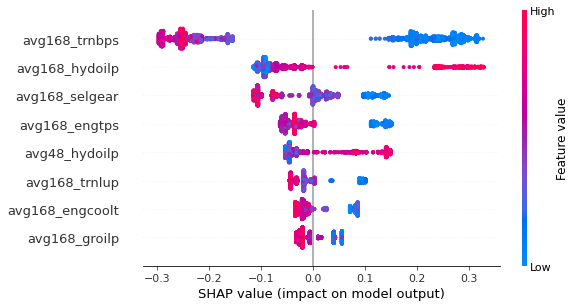

In [7]:
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values = explainerXGB.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=8)

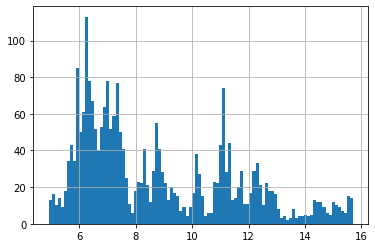

In [8]:
X_test.avg168_trnbps.hist(bins=100)

In [9]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

In [10]:
explainer = ClassifierExplainer(
    xgb_model, X_test.reset_index(drop=True), y_test, 
    )
 
db = ExplainerDashboard(explainer, 
                        title="khgm", # defaults to "Model Explainer"
                        shap_interaction=True, # you can switch off tabs with bools
                        )
db.run(port=2021)

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...
Generating xgboost m

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and incr

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and incr

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and incr

Calculating prediction probabilities...
Calculating classification_dfs...


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Calculating liftcurve_dfs...
Calculating pred_percentiles...
Calculating pr auc curves...
Calculating predictions...
Calculating confusion matrices...


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Calculating roc auc curves...
Calculating metrics...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.0.31:2021
Dash is running on http://0.0.0.0:2021/

 * Serving Flask app "explainerdashboard.dashboards" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:2021/ (Press CTRL+C to quit)


In [11]:
import pickle

pickle.dump(xgb_model, open('../models/model_xgb_silnik.pkl', 'wb'))